# Images médicales CT
DICOM visualisation

Images CT des archives d’imagerie du cancer avec contraste et âge du patient

L’ensemble de données est conçu pour permettre de tester différentes méthodes pour examiner les tendances des données d’image CT associées à l’utilisation du contraste et de l’âge du patient. L’idée de base est d’identifier les textures d’image, les modèles statistiques et les caractéristiques fortement corrélés avec ces traits et éventuellement de construire des outils simples pour classer automatiquement ces images lorsqu’elles ont été mal classées (ou trouver des valeurs aberrantes qui pourraient être des cas suspects, de mauvaises mesures ou des machines mal calibrées).

In [28]:
import numpy as np
import pandas as pd
from skimage.io import imread
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from glob import glob
import pydicom as dicom
import dicom
import os

In [7]:
PATH="./data"
print(os.listdir(PATH))

['dicom_dir', 'full_archive.npz', 'overview.csv', 'tiff_images']


## 1- Lecture  des données

In [43]:
data_df = pd.read_csv(os.path.join(PATH,"overview.csv"))
data_df.head()

,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


## Lire les données TIFF

In [11]:
print("Number of TIFF images:", len(os.listdir(os.path.join(PATH,"tiff_images"))))

Number of TIFF images: 100


In [12]:
tiff_data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH + 'tiff_images/*.tif')])

Process TIFF data

We define a function to process data.
We extract file, ID, age, contrast, modality information from path info

In [44]:
def process_data(path):
    data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH+path)])
    data['file'] = data['path'].map(os.path.basename)
    data['ID'] = data['file'].map(lambda x: str(x.split('_')[1]))
    data['Age'] = data['file'].map(lambda x: int(x.split('_')[3]))
    data['Contrast'] = data['file'].map(lambda x: bool(int(x.split('_')[5])))
    data['Modality'] = data['file'].map(lambda x: str(x.split('_')[6].split('.')[-2]))
    return data

In [46]:
tiff_data = process_data(path = '/tiff_images/*.tif')

Check TIFF data

Let's check the TIFF data, after we extracted the meta info from the file name.

In [47]:
tiff_data.head(10)

,path,file,ID,Age,Contrast,Modality
0,./data/tiff_images\ID_0000_AGE_0060_CONTRAST_1...,ID_0000_AGE_0060_CONTRAST_1_CT.tif,0000,60,True,CT
1,./data/tiff_images\ID_0001_AGE_0069_CONTRAST_1...,ID_0001_AGE_0069_CONTRAST_1_CT.tif,0001,69,True,CT
2,./data/tiff_images\ID_0002_AGE_0074_CONTRAST_1...,ID_0002_AGE_0074_CONTRAST_1_CT.tif,0002,74,True,CT
3,./data/tiff_images\ID_0003_AGE_0075_CONTRAST_1...,ID_0003_AGE_0075_CONTRAST_1_CT.tif,0003,75,True,CT
4,./data/tiff_images\ID_0004_AGE_0056_CONTRAST_1...,ID_0004_AGE_0056_CONTRAST_1_CT.tif,0004,56,True,CT
5,./data/tiff_images\ID_0005_AGE_0048_CONTRAST_1...,ID_0005_AGE_0048_CONTRAST_1_CT.tif,0005,48,True,CT
6,./data/tiff_images\ID_0006_AGE_0075_CONTRAST_1...,ID_0006_AGE_0075_CONTRAST_1_CT.tif,0006,75,True,CT
7,./data/tiff_images\ID_0007_AGE_0061_CONTRAST_1...,ID_0007_AGE_0061_CONTRAST_1_CT.tif,0007,61,True,CT
8,./data/tiff_images\ID_0008_AGE_0051_CONTRAST_1...,ID_0008_AGE_0051_CONTRAST_1_CT.tif,0008,51,True,CT
9,./data/tiff_images\ID_0009_AGE_0048_CONTRAST_1...,ID_0009_AGE_0048_CONTRAST_1_CT.tif,0009,48,True,CT


Lire les donnéees DICOM

Repetition

In [49]:
print("Number of DICOM files:", len(os.listdir(PATH+"/dicom_dir")))

Number of DICOM files: 100


Process DICOM data

In [51]:
dicom_data = process_data('/dicom_dir/*.dcm')

In [52]:
dicom_data.head(10)

,path,file,ID,Age,Contrast,Modality
0,./data/dicom_dir\ID_0000_AGE_0060_CONTRAST_1_C...,ID_0000_AGE_0060_CONTRAST_1_CT.dcm,0000,60,True,CT
1,./data/dicom_dir\ID_0001_AGE_0069_CONTRAST_1_C...,ID_0001_AGE_0069_CONTRAST_1_CT.dcm,0001,69,True,CT
2,./data/dicom_dir\ID_0002_AGE_0074_CONTRAST_1_C...,ID_0002_AGE_0074_CONTRAST_1_CT.dcm,0002,74,True,CT
3,./data/dicom_dir\ID_0003_AGE_0075_CONTRAST_1_C...,ID_0003_AGE_0075_CONTRAST_1_CT.dcm,0003,75,True,CT
4,./data/dicom_dir\ID_0004_AGE_0056_CONTRAST_1_C...,ID_0004_AGE_0056_CONTRAST_1_CT.dcm,0004,56,True,CT
5,./data/dicom_dir\ID_0005_AGE_0048_CONTRAST_1_C...,ID_0005_AGE_0048_CONTRAST_1_CT.dcm,0005,48,True,CT
6,./data/dicom_dir\ID_0006_AGE_0075_CONTRAST_1_C...,ID_0006_AGE_0075_CONTRAST_1_CT.dcm,0006,75,True,CT
7,./data/dicom_dir\ID_0007_AGE_0061_CONTRAST_1_C...,ID_0007_AGE_0061_CONTRAST_1_CT.dcm,0007,61,True,CT
8,./data/dicom_dir\ID_0008_AGE_0051_CONTRAST_1_C...,ID_0008_AGE_0051_CONTRAST_1_CT.dcm,0008,51,True,CT
9,./data/dicom_dir\ID_0009_AGE_0048_CONTRAST_1_C...,ID_0009_AGE_0048_CONTRAST_1_CT.dcm,0009,48,True,CT


## 2- Exploration des données

In [53]:
def countplot_comparison(feature):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16, 4))
    s1 = sns.countplot(data_df[feature], ax=ax1)
    s1.set_title("Overview data")
    s2 = sns.countplot(tiff_data[feature], ax=ax2)
    s2.set_title("Tiff files data")
    s3 = sns.countplot(dicom_data[feature], ax=ax3)
    s3.set_title("Dicom files data")
    plt.show()

C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

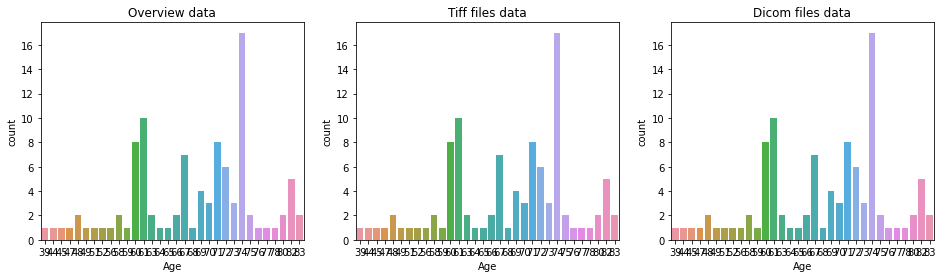

In [63]:
countplot_comparison('Age')

In [82]:
def show_images(data, dim=16, imtype='TIFF'):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4,4, figsize=(16,20))
    for i,data_row in enumerate(img_data):
        if(imtype=='TIFF'): 
            data_row_img = imread(data_row['path'])
        elif(imtype=='DICOM'):
            data_row_img = dicom.read_file(data_row['path'])
        if(imtype=='TIFF'):
            ax[i//4, i%4].matshow(data_row_img,cmap='gray')
        elif(imtype=='DICOM'):
            ax[i//4, i%4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast}'.format(**data_row))
    plt.show()

In [87]:
def show_images(data, dim=16, imtype='TIFF'):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4,4, figsize=(16,20))
    for i,data_row in enumerate(img_data):
        data_row_img = imread(data_row['path'])       
        ax[i//4, i%4].matshow(data_row_img,cmap='gray')         
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title('Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast}'.format(**data_row))
    plt.show()

In [88]:
def show_dicom_images(data):
    img_data = list(data[:16].T.to_dict().values())
    f, ax = plt.subplots(4,4, figsize=(16,20))
    for i,data_row in enumerate(img_data):

        data_row_img = dicom.read_file(data_row['path'])
        modality = data_row_img.Modality
        age = data_row_img.PatientAge
        
        ax[i//4, i%4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title('Modality: {} Age: {}\nSlice: {} Contrast: {}'.format(
         modality, age, data_row['ID'], data_row['Contrast']))
    plt.show()

In [61]:
data_df[:10].T.to_dict().values()

dict_values([{'Unnamed: 0': 0, 'Age': 60, 'Contrast': True, 'ContrastTag': 'NONE', 'raw_input_path': '../data/50_50_dicom_cases\\Contrast\\00001 (1).dcm', 'id': 0, 'tiff_name': 'ID_0000_AGE_0060_CONTRAST_1_CT.tif', 'dicom_name': 'ID_0000_AGE_0060_CONTRAST_1_CT.dcm'}, {'Unnamed: 0': 1, 'Age': 69, 'Contrast': True, 'ContrastTag': 'NONE', 'raw_input_path': '../data/50_50_dicom_cases\\Contrast\\00001 (10).dcm', 'id': 1, 'tiff_name': 'ID_0001_AGE_0069_CONTRAST_1_CT.tif', 'dicom_name': 'ID_0001_AGE_0069_CONTRAST_1_CT.dcm'}, {'Unnamed: 0': 2, 'Age': 74, 'Contrast': True, 'ContrastTag': 'APPLIED', 'raw_input_path': '../data/50_50_dicom_cases\\Contrast\\00001 (11).dcm', 'id': 2, 'tiff_name': 'ID_0002_AGE_0074_CONTRAST_1_CT.tif', 'dicom_name': 'ID_0002_AGE_0074_CONTRAST_1_CT.dcm'}, {'Unnamed: 0': 3, 'Age': 75, 'Contrast': True, 'ContrastTag': 'NONE', 'raw_input_path': '../data/50_50_dicom_cases\\Contrast\\00001 (12).dcm', 'id': 3, 'tiff_name': 'ID_0003_AGE_0075_CONTRAST_1_CT.tif', 'dicom_name': 

Visualisation de TIFF

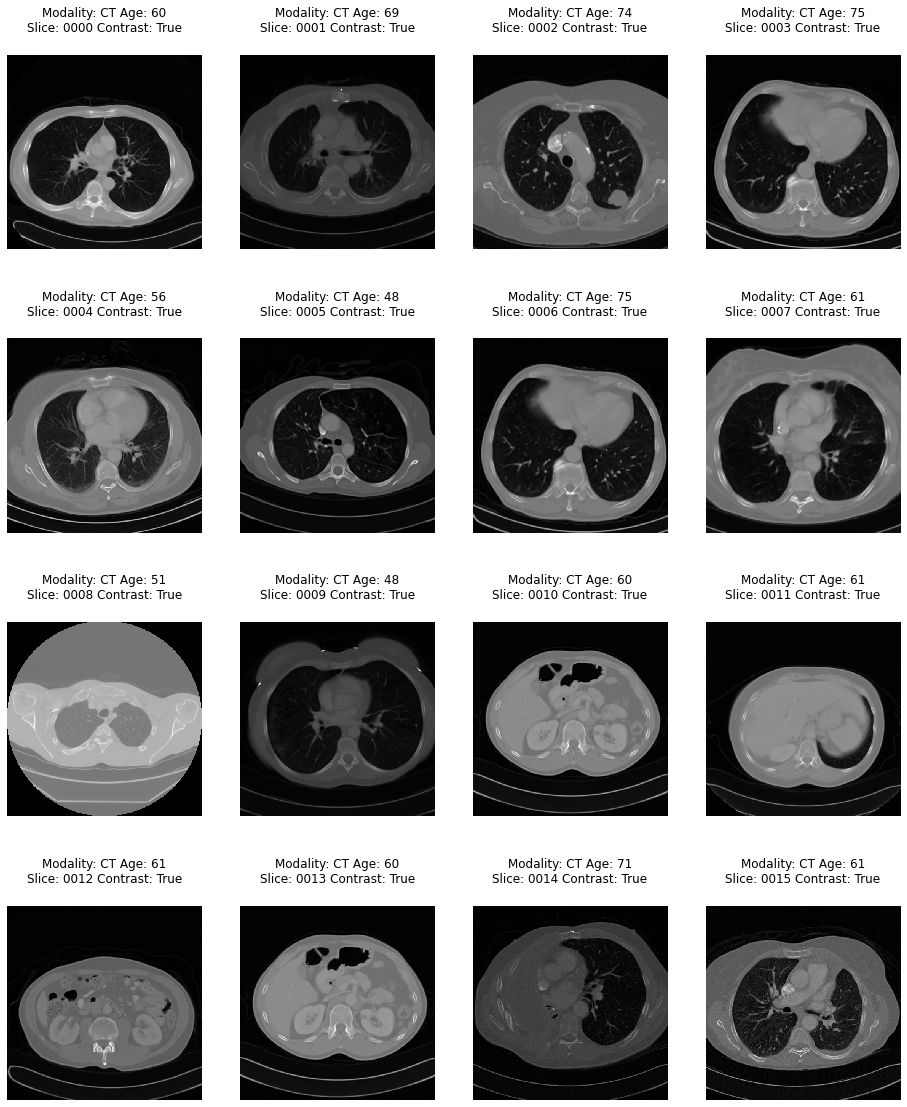

In [70]:
show_images(tiff_data,16,'TIFF')

Visualisation de DICOM

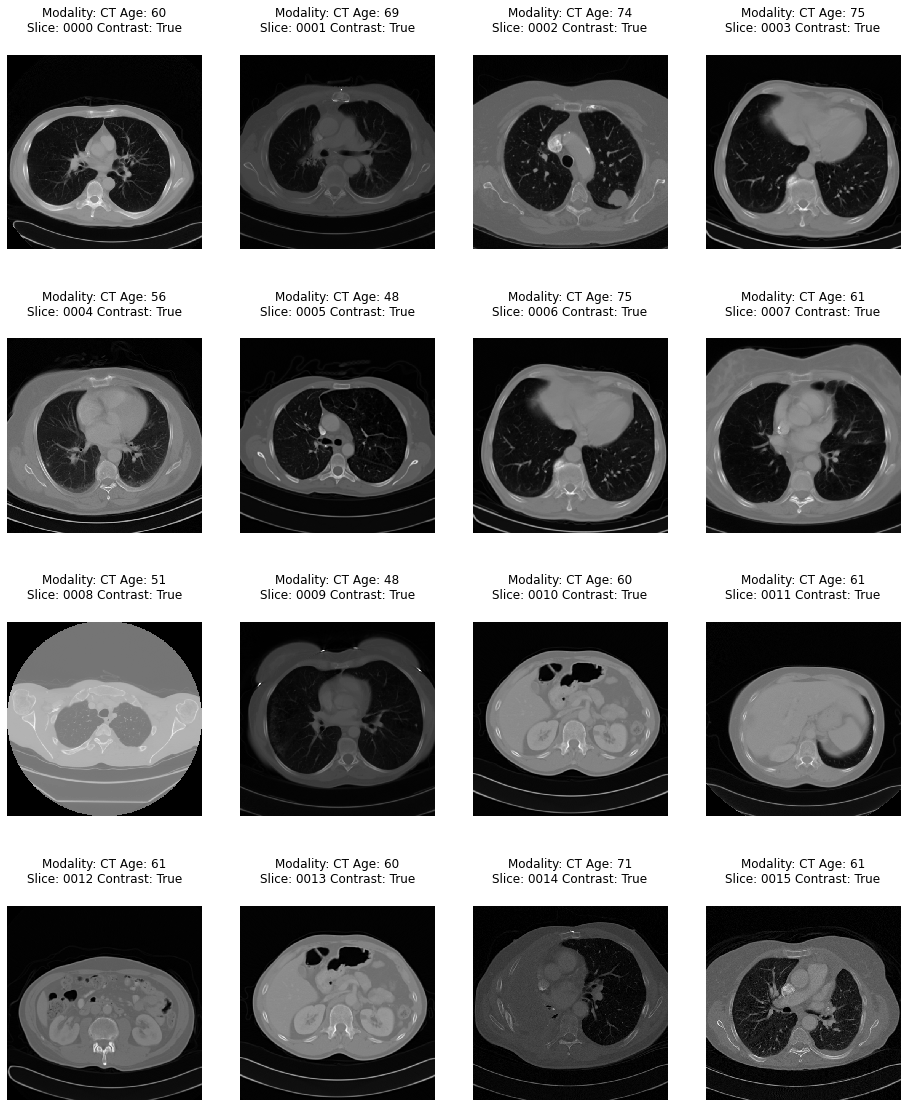

In [90]:
show_images(dicom_data,16,'DICOM')